# Rotation Curve Notebook
---


In [1]:
import sys
sys.path.append("../gaia_tools/")
sys.path.append("../scripts/")
import data_analysis
import covariance_generation as cov
from import_functions import import_data
import photometric_cut
from mcmc_plots import *
import numpy as np
import emcee
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle
from pylab import *
from scipy.optimize import curve_fit
from cProfile import label
import pandas as pd

In [2]:
headers = ['R', 'v_c', 'sig_below', 'sig_above']
eilers_rc = pd.read_csv("/home/svenpoder/repos/gaia-tools/jupyter-notebook/Eilers_RC_Data.csv", sep=' ', names=headers)
eilers_rc.columns

Index(['R', 'v_c', 'sig_below', 'sig_above'], dtype='object')

In [16]:
type(np.array(eilers_rc.R))

numpy.ndarray

In [3]:
# Rotation Curve Plotting Function

from tkinter import Y
from turtle import color


def plot_rotation_curve(is_fit_curve, mcmc_runs, labels, burnin, display_eilers=False, display_bin_edges=False):

    def func(x, a, b, c, ):
        return a*x*x + b*x + c

    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['black', 'orange', 'blue']
    
    for i_path, path in enumerate(mcmc_runs):
        reader = emcee.backends.HDFBackend(path, read_only=True)
        samples_data = reader.get_chain(discard=burnin)
        flatchain = reader.get_chain(flat=True, discard = burnin)

        bin_velocities = []
        ndim = samples_data.shape[2]
        
        for i in range(ndim):
            mcmc = np.percentile(flatchain[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            v_mean, v_sub, v_sup = mcmc[1], q[0], q[1] 
            bin_velocities.append((v_mean, v_sub, v_sup))
        velocity_array = np.array(bin_velocities)

        if(len(mcmc_runs) == 0):
            x_offset = 0
            x_values = bin_centers_r + x_offset
        else:
            x_offset = [-10, 0, 10]
            x_values = bin_centers_r + x_offset[i_path]
        y_values = velocity_array[:,0]

        y_error = [velocity_array[:,1], velocity_array[:,2]]
        plt.errorbar(x_values, -y_values,
                    yerr= y_error,
                    fmt='o', c=colors[i_path])


        if(is_fit_curve):
            popt, pcov = curve_fit(func, bin_centers_r, -y_values, sigma=velocity_array[:,1])
            perr = np.sqrt(np.diag(pcov))
            fit = func(np.array(bin_centers_r), popt[0], popt[1], popt[2])
            plot(bin_centers_r, fit, colors[i_path], lw=2, linestyle="-", alpha=0.75, label=labels[i_path])

        # popt_up = popt + 1*perr
        # popt_dw = popt - 1*perr
        # fit_up = func(np.array(x_values), *popt_up)
        # fit_dw = func(np.array(x_values), *popt_dw)
        # ax.fill_between(x_values, 
        #                 fit_up,
        #                 fit_dw, color='gray', alpha=.25)

    plt.xlabel(r'$r$ [kpc]', fontdict={'fontsize' : 16})
    plt.ylabel(r'$v_c$ [km/s]',  fontdict={'fontsize' : 16})

    def numfmt(x, pos):
            s = '{}'.format(x / 1000.0)
            return s
    fmt = ticker.FuncFormatter(numfmt)
    ax.xaxis.set_major_formatter(fmt)

    bin_edges_r = bin_setup['bin_edges'][0][0]
    bin_edges_z = bin_setup['bin_edges'][1].T[0]

    if(display_bin_edges):
        ax.vlines(bin_edges_r, -np.min(y_values) + 1, -np.max(y_values) - 1, linestyles='dashed', alpha=0.5, colors='grey')
        ax.set_xticks(np.round(bin_edges_r))

    if(display_eilers):
        reduced_eilers = eilers_rc[eilers_rc.R <= 12]
        eilers_rc_y_values = np.array(reduced_eilers.v_c)
        eilers_rc_x_values = np.array(reduced_eilers.R*1e3)
        eilers_y_error = [np.array(reduced_eilers.sig_below), np.array(reduced_eilers.sig_above)]
        plt.errorbar(eilers_rc_x_values, eilers_rc_y_values, 
                    yerr=eilers_y_error, 
                    fmt='o', 
                    color='red',
                    label='Eilers et al. (2018)')
    plt.legend()
 
    r_range = r', $r \in [{},{}]$ kpc'.format(np.round(bin_edges_r[0]/1000), np.round(bin_edges_r[-1]/1000))
    z_range = r', $z \in [{},{}]$ pc'.format(np.round(bin_edges_z[0]), np.round(bin_edges_z[-1]))
    plt.title('Rotation Curve' + r_range + z_range, fontsize=18, pad=12)

    y_min = np.min(np.concatenate([eilers_rc_y_values, -y_values]))
    y_max = np.max(np.concatenate([eilers_rc_y_values, -y_values]))
    plt.xlim(5000, 12000)
    plt.ylim(y_min-3, y_max+3)
    plt.show()

In [4]:
# Rotation Curve Residual Plotting Function

def plot_residuals(mcmc_runs, burnin, eq_label):

    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['black', 'orange', 'blue']
    
    velocities = []

    for i_path, path in enumerate(mcmc_runs):
        reader = emcee.backends.HDFBackend(path, read_only=True)
        samples_data = reader.get_chain(discard=burnin)
        flatchain = reader.get_chain(flat=True, discard = burnin)

        bin_velocities = []
        ndim = samples_data.shape[2]
        
        for i in range(ndim):
            mcmc = np.percentile(flatchain[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            v_mean, v_sub, v_sup = mcmc[1], q[0], q[1] 
            bin_velocities.append(v_mean)
        velocity_array = np.array(bin_velocities)
        velocities.append(velocity_array)

    velocity_array = np.abs(np.array(velocities))
    vel_residuals = np.abs(velocity_array[0,:] - velocity_array[1,:])/velocity_array[0,:] 
    print(velocity_array)
    print(vel_residuals.shape)
    plt.plot(bin_centers_r, vel_residuals, label=eq_label)

    plt.xlabel(r'$r$ [kpc]', fontdict={'fontsize' : 16})
    plt.ylabel(r'$\Delta{v_c}/v_c $',  fontdict={'fontsize' : 16})

    def numfmt(x, pos):
            s = '{}'.format(x / 1000.0)
            return s
    fmt = ticker.FuncFormatter(numfmt)
    ax.xaxis.set_major_formatter(fmt)

    bin_edges_r = bin_setup['bin_edges'][0][0]
    bin_edges_z = bin_setup['bin_edges'][1].T[0]

    ax.vlines(bin_edges_r, np.min(vel_residuals) , np.max(vel_residuals) , linestyles='dashed', alpha=0.5, colors='grey')
    ax.set_xticks(np.round(bin_edges_r))

    r_range = r', $r \in [{},{}]$ kpc'.format(np.round(bin_edges_r[0]/1000), np.round(bin_edges_r[-1]/1000))
    z_range = r', $z \in [{},{}]$ pc'.format(np.round(bin_edges_z[0]), np.round(bin_edges_z[-1]))
    #plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.legend()
    plt.title('Velocity Curve Residuals' + r_range + z_range, fontsize=18, pad=12)
    plt.show()

---

## Old Results

No handles with labels found to put in legend.


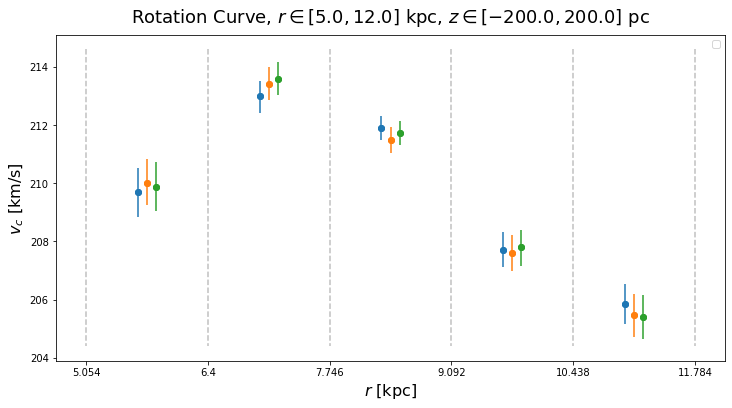

In [68]:
mcmc_runs = ['/home/sven/repos/gaia-tools/out/mcmc_runs/2022-06-20-18-09-19_range0.15/sampler_2022-06-20-18-09-19.h5',
            '/home/sven/repos/gaia-tools/out/mcmc_runs/2022-06-20-18-12-50_range0.3/sampler_2022-06-20-18-12-50.h5',
            '/home/sven/repos/gaia-tools/out/mcmc_runs/2022-06-20-18-16-29_range0.45/sampler_2022-06-20-18-16-29.h5']

input_path = "/home/sven/repos/gaia-tools/out/mcmc_runs/2022-06-20-16-58-46/bin_settings.txt"
with open(input_path, 'rb') as handle:
    data = handle.read()
bin_setup = pickle.loads(data)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

labels = ['cut range = 0.15', 'cut range = 0.3', 'cut range = 0.45']
plot_rotation_curve(False, mcmc_runs, labels, 250)


### Increased Binning

In [51]:
# Load binning info

path = "/home/sven/repos/gaia-tools/out/mcmc_runs/2022-06-21-10-00-16_range0.3/bin_settings.txt"
with open(path, 'rb') as handle:
    data = handle.read()
bin_setup = pickle.loads(data)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']
print(bin_centers_r)

[ 5401.45068497  6095.55623508  6789.66178518  7483.76733529
  8177.8728854   8871.9784355   9566.08398561 10260.18953571
 10954.29508582 11648.40063593]


In [23]:
# Load sampler info

sampler_path = '/home/sven/repos/gaia-tools/out/mcmc_runs/2022-06-21-10-10-36_range0.3/sampler_2022-06-21-10-10-36.h5'
reader = emcee.backends.HDFBackend(sampler_path, read_only=True)
samples_data = reader.get_chain(discard=2200)
flatchain = reader.get_chain(flat=True, discard = 2200)

xdf = [num for num in range(0, samples_data.shape[2], 1)]
theta_labels = [r'$V_{c%s}$' %str(i+1) for i in xdf]

In [24]:
from IPython.display import display, Math
#theta_labels = ['U_{sun}','V_{sun}']
theta_labels = ['V_{c%s}' %str(i+1) for i in xdf]
for i in range(len(theta_labels)):
    mcmc = np.percentile(flatchain[:, i], [16, 50, 84])
    
    q = np.diff(mcmc)
    
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], theta_labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Sampler shape: (3800, 50, 10)


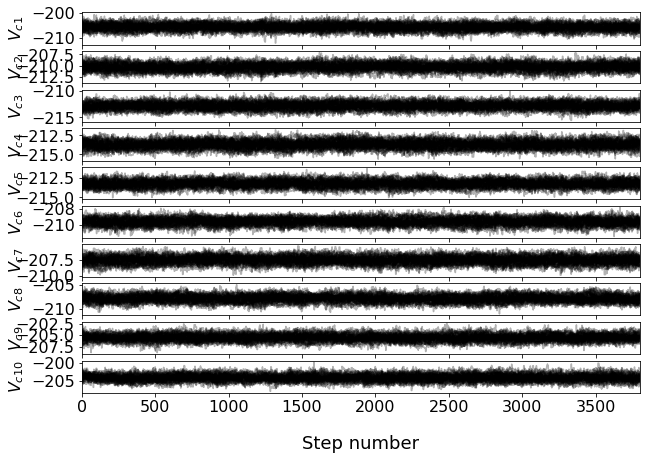

In [12]:
plot_walkers(reader, theta_labels, 2200)

(190000, 10)


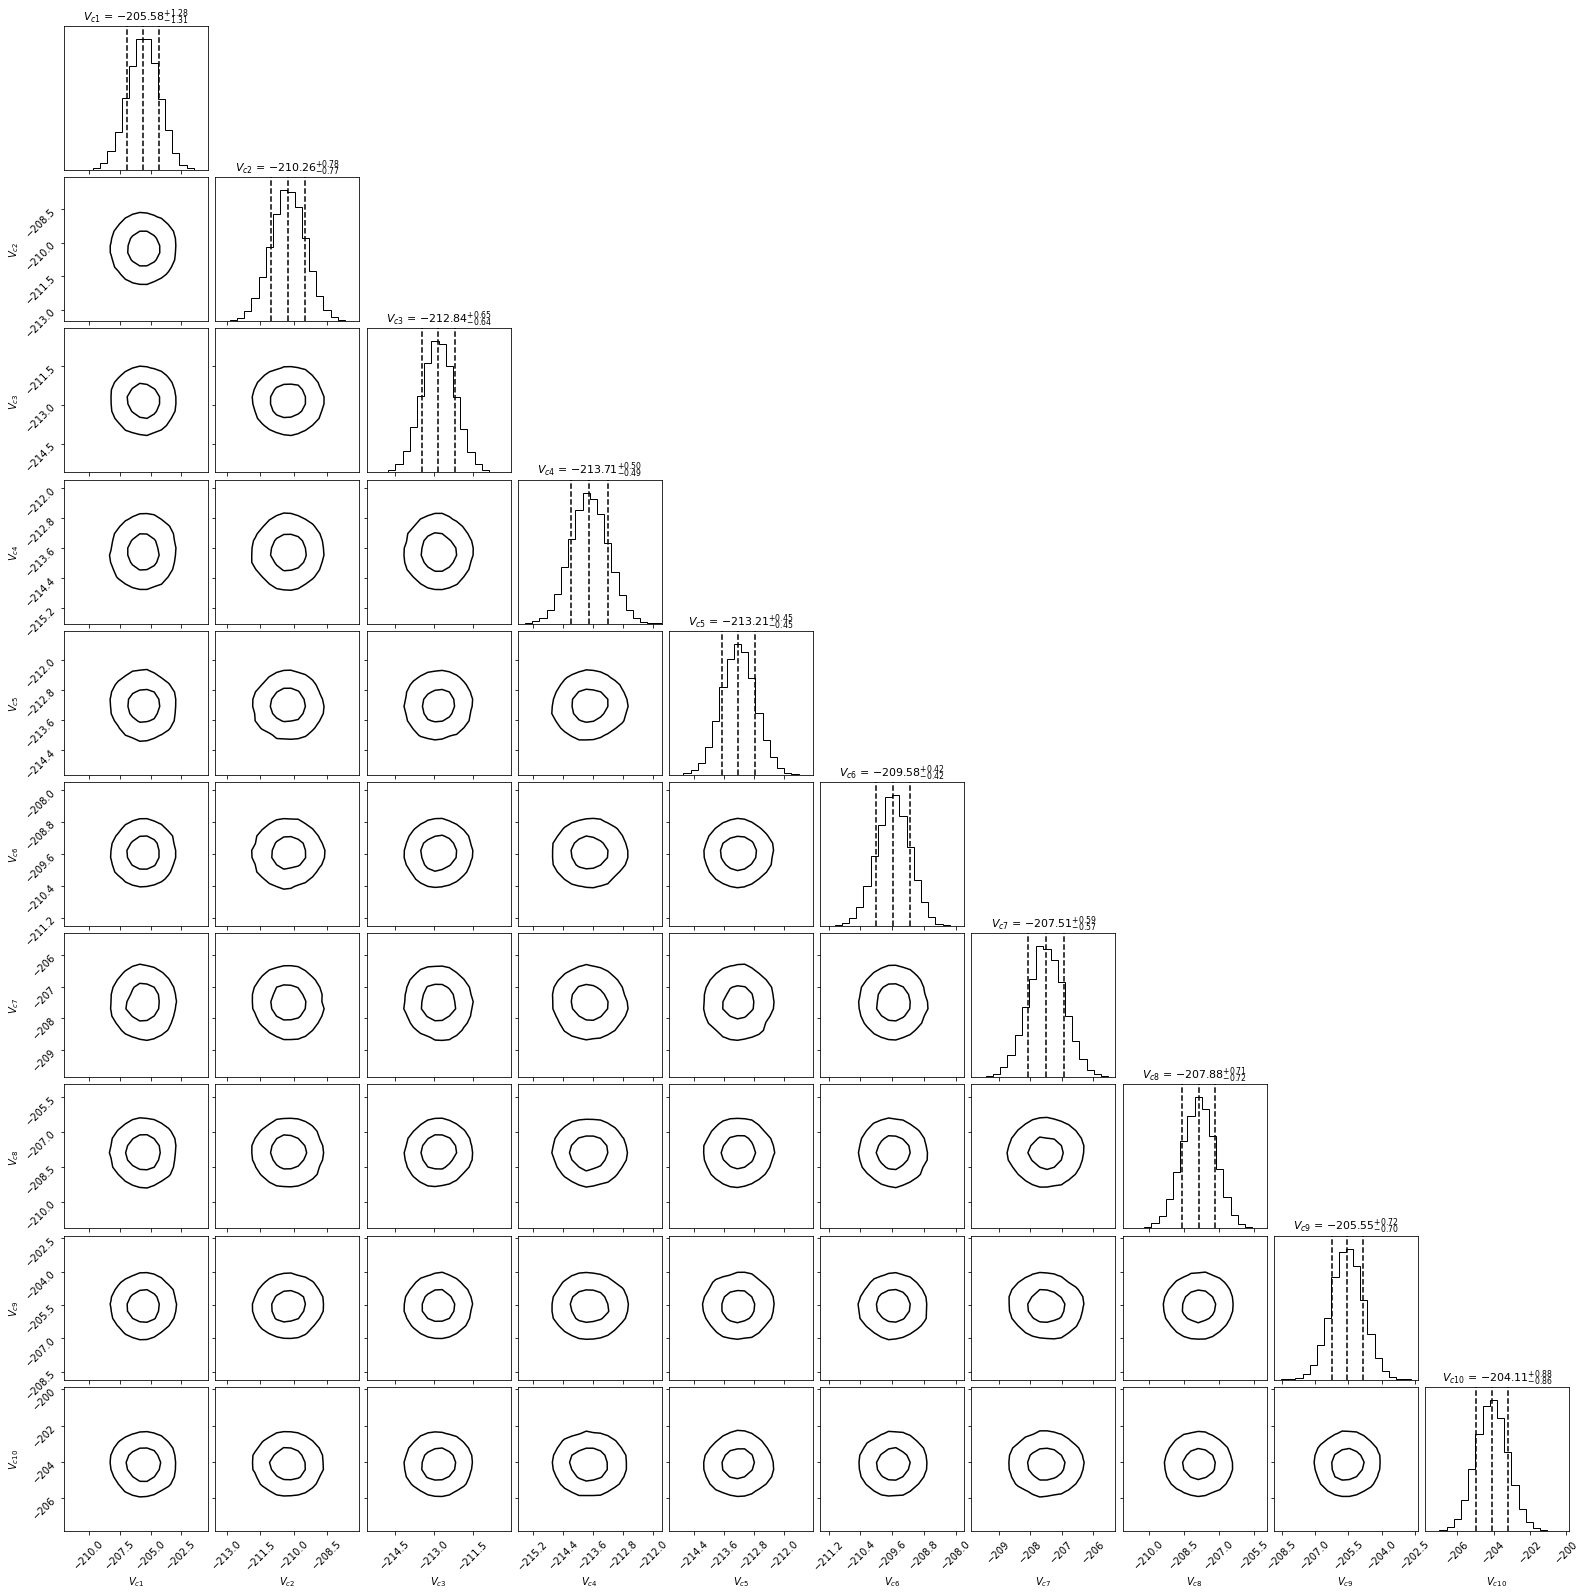

In [14]:
plot_corner(reader, theta_labels, 2200)

ValueError: x and y must be the same size

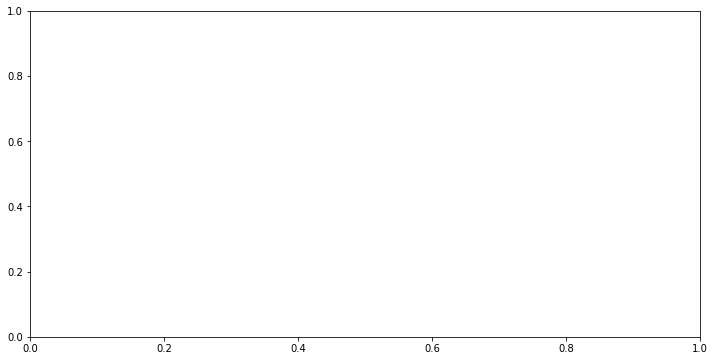

In [69]:
mcmc_runs = '/home/sven/repos/gaia-tools/out/mcmc_runs/2022-06-21-10-10-36_range0.3/sampler_2022-06-21-10-10-36.h5'
labels = ['cut range = 0.3, bins = 10']
plot_rotation_curve(True, [mcmc_runs], labels, 2200)

---

## New Results (September, 2022 - ...)

### First Result

In [9]:
# Load binning info

path = "/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-12-14-30-07_range0.3/run_settings.txt"
with open(path, 'rb') as handle:
    data = handle.read()
bin_setup = pickle.loads(data)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']


FileNotFoundError: [Errno 2] No such file or directory: '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-12-14-30-07_range0.3/run_settings.txt'

In [4]:
# Load sampler info

sampler_path = "/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-12-14-30-07_range0.3/sampler_2022-09-12-14-30-07.h5"
reader = emcee.backends.HDFBackend(sampler_path, read_only=True)
samples_data = reader.get_chain(discard=4000)
flatchain = reader.get_chain(flat=True, discard = 4000)

xdf = [num for num in range(0, samples_data.shape[2], 1)]
theta_labels = [r'$V_{c%s}$' %str(i+1) for i in xdf]

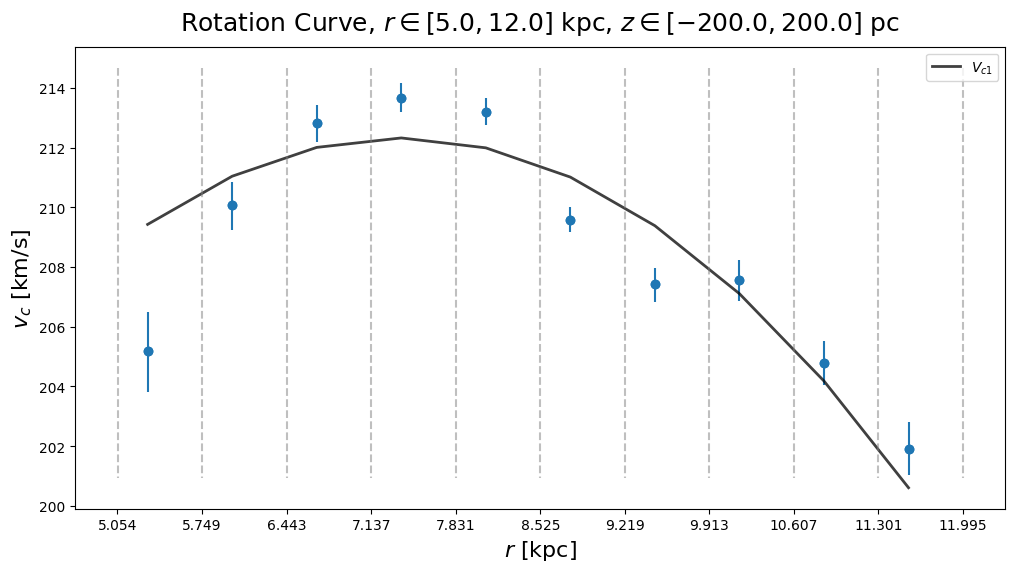

In [6]:
plot_rotation_curve(True, [sampler_path], theta_labels, 4000)

In [10]:
# Rotation curve
# r 5 - 20 kpc
# z -500 - 500 pc


# Load binning info

path = "/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-13-15-17-18_range0.3/run_settings.txt"
with open(path, 'rb') as handle:
    data = handle.read()
bin_setup = pickle.loads(data)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

Sampler shape: (5000, 50, 10)


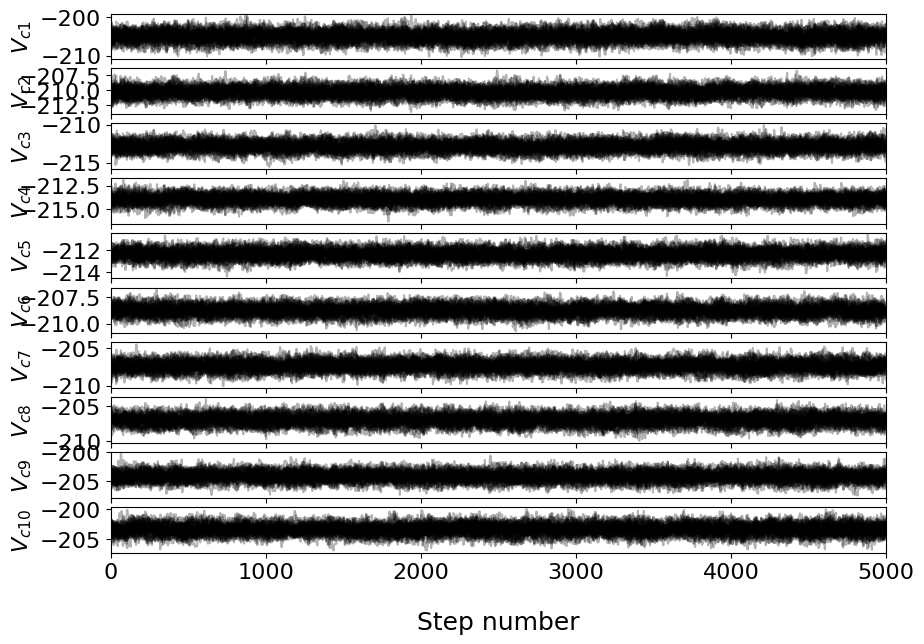

In [12]:
sampler_path = "/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-13-15-17-18_range0.3/sampler_2022-09-13-15-17-18.h5"

reader = emcee.backends.HDFBackend(sampler_path, read_only=True)
samples_data = reader.get_chain(discard=2000)
flatchain = reader.get_chain(flat=True, discard = 2000)

xdf = [num for num in range(0, samples_data.shape[2], 1)]
theta_labels = [r'$V_{c%s}$' %str(i+1) for i in xdf]

plot_walkers(reader, theta_labels, burn_in=2000)

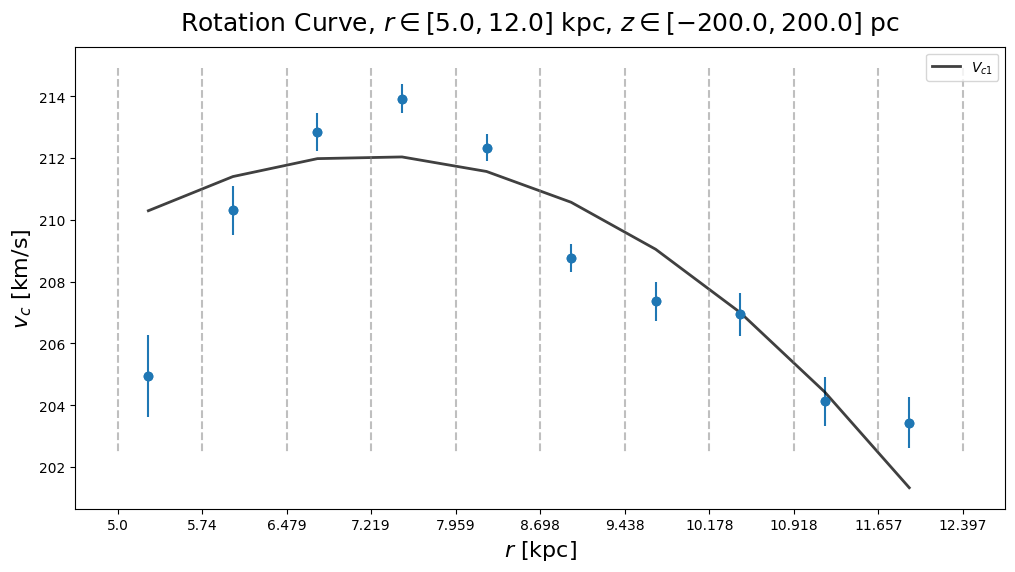

In [14]:
plot_rotation_curve(True, [sampler_path], theta_labels, 2000)

### Varying Radial Velocity Dispersion Scale Length

In [27]:
# Load run settings
path_1 = "/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-19-14-23-06_range0.3/run_settings.txt"
path_2 = "/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-19-14-29-10_range0.3/run_settings.txt"
path_3 = "/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-19-14-35-06_range0.3/run_settings.txt"
paths = [path_1, path_2, path_3]

sampler_path_1 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-19-14-23-06_range0.3/sampler_2022-09-19-14-23-06.h5'
sampler_path_2 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-19-14-29-10_range0.3/sampler_2022-09-19-14-29-10.h5'
sampler_path_3 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-19-14-35-06_range0.3/sampler_2022-09-19-14-35-06.h5'
samplers = [sampler_path_1, sampler_path_2, sampler_path_3]

with open(path_1, 'rb') as handle:
    data = handle.read()

# Assuming all three runs have same binning scheme
bin_setup = pickle.loads(data)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

labels = []
for setup_path in paths:
    with open(setup_path, 'rb') as handle:
        bin_setup = pickle.loads(handle.read())
        labels.append(r'$h_\sigma = {}$ pc'.format(bin_setup['vlos_dispersion_scale']))

print(labels)


['$h_\\sigma = 8000.0$ pc', '$h_\\sigma = 16000.0$ pc', '$h_\\sigma = 24000.0$ pc']


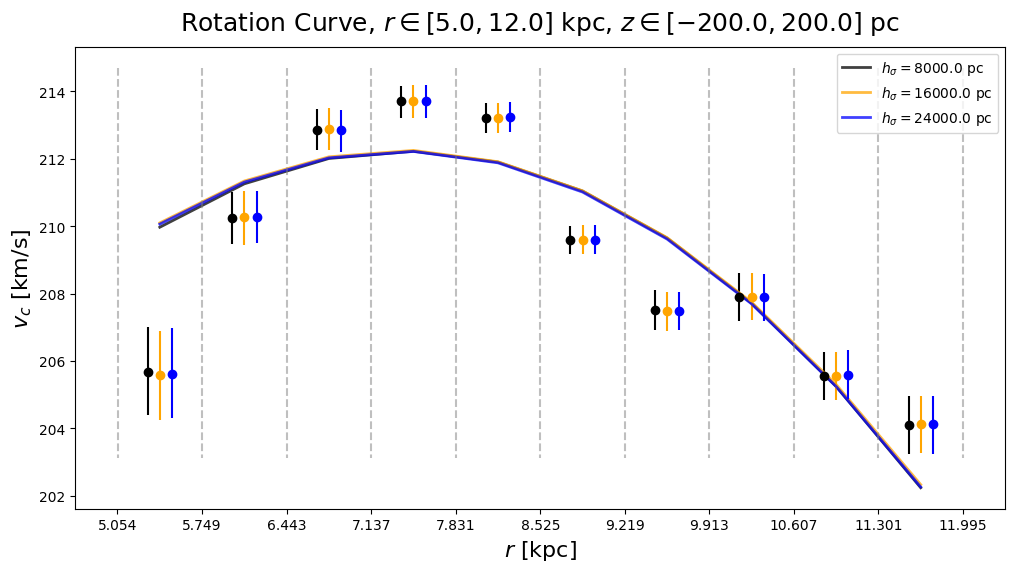

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[205.59561029 210.25806598 212.86966333 213.7148272  213.22037529
  209.60036013 207.47759897 207.90707984 205.56068506 204.1313716 ]
 [205.62365555 210.26421301 212.84084422 213.70181137 213.23022416
  209.59637844 207.48960508 207.89757013 205.59057054 204.11645024]]
(10,)


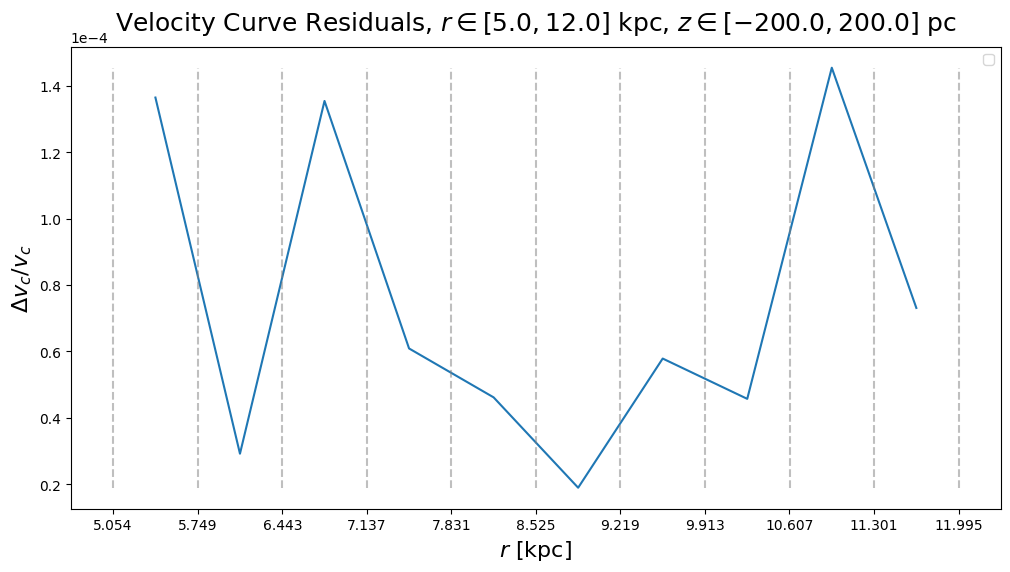

In [24]:
plot_rotation_curve(True, samplers, labels, 2000)
plot_residuals(samplers[1:], 2000, "")

#### Comparing Radial Velocity Disp. Adopted From Eilers et al

In [31]:
# Load run settings
path_1 = "/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-19-14-29-10_range0.3/run_settings.txt"
path_2 = "/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-20-15-42-29_range0.3/run_settings.txt"
paths = [path_1, path_2]

sampler_path_1 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-19-14-29-10_range0.3/sampler_2022-09-19-14-29-10.h5'
sampler_path_2 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-20-15-42-29_range0.3/sampler_2022-09-20-15-42-29.h5'
samplers = [sampler_path_1, sampler_path_2]

with open(path_1, 'rb') as handle:
    data = handle.read()

# Assuming all three runs have same binning scheme
bin_setup = pickle.loads(data)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

labels = []
for setup_path in paths:
    with open(setup_path, 'rb') as handle:
        bin_setup = pickle.loads(handle.read())
        labels.append(r'$h_\sigma = {}$ pc'.format(bin_setup['vlos_dispersion_scale']))

print(labels)

['$h_\\sigma = 16000.0$ pc', '$h_\\sigma = 21000.0$ pc']


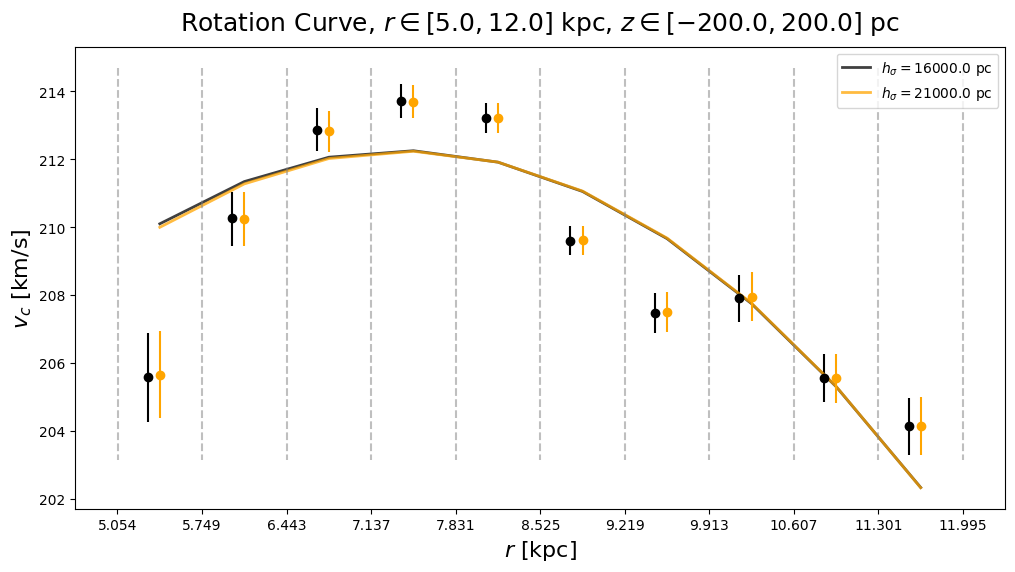

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[205.59561029 210.25806598 212.86966333 213.7148272  213.22037529
  209.60036013 207.47759897 207.90707984 205.56068506 204.1313716 ]
 [205.64671812 210.24862848 212.83033651 213.69330246 213.21483741
  209.60890572 207.50391555 207.9418262  205.54948937 204.13647588]]
(10,)


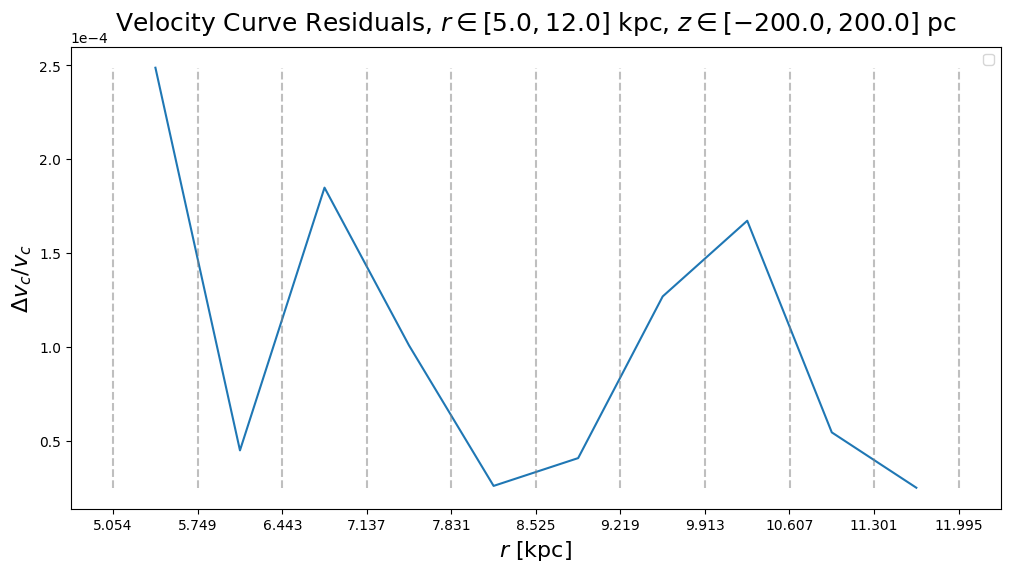

In [33]:
plot_rotation_curve(True, samplers, labels, 2000)
plot_residuals(samplers, 2000, "")

### Varying Disk Scale Length

In [25]:
# Load run settings
path_1 = "/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-20-10-18-42_range0.3/run_settings.txt"
path_2 = "/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-20-10-24-42_range0.3/run_settings.txt"
path_3 = "/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-20-10-30-37_range0.3/run_settings.txt"
paths = [path_1, path_2, path_3]

with open(path_1, 'rb') as handle:
    data = handle.read()

# Assuming all three runs have same binning scheme
bin_setup = pickle.loads(data)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

labels = []
for setup_path in paths:
    with open(setup_path, 'rb') as handle:
        bin_setup = pickle.loads(handle.read())
        labels.append(r'$h_r = {}$ pc'.format(bin_setup['disk_scale']))

print(labels)

['$h_r = 2000.0$ pc', '$h_r = 3000.0$ pc', '$h_r = 4000.0$ pc']


0
1
2


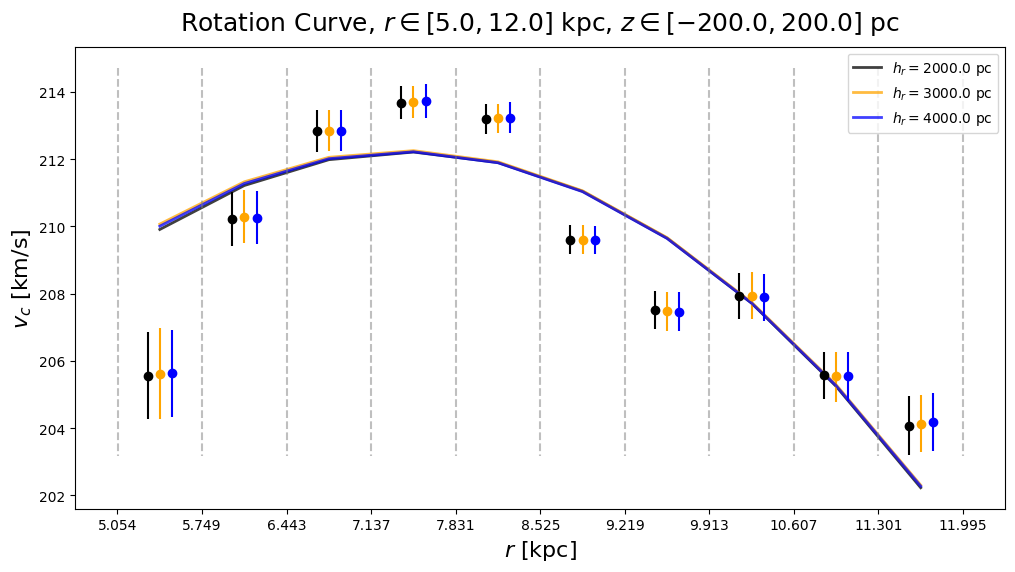

In [7]:
sampler_path_1 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-20-10-18-42_range0.3/sampler_2022-09-20-10-18-42.h5'
sampler_path_2 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-20-10-24-42_range0.3/sampler_2022-09-20-10-24-42.h5'
sampler_path_3 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-20-10-30-37_range0.3/sampler_2022-09-20-10-30-37.h5'

samplers = [sampler_path_1, sampler_path_2, sampler_path_3]
plot_rotation_curve(True, samplers, labels, 4000)

[[205.6027462  210.27489702 212.85332189 213.69784295 213.22490143
  209.61027817 207.47359166 207.93365505 205.54210405 204.12188135]
 [205.62695904 210.25148835 212.84589552 213.72231099 213.23659041
  209.6073295  207.46855046 207.89072701 205.54418806 204.16727874]]
(10,)


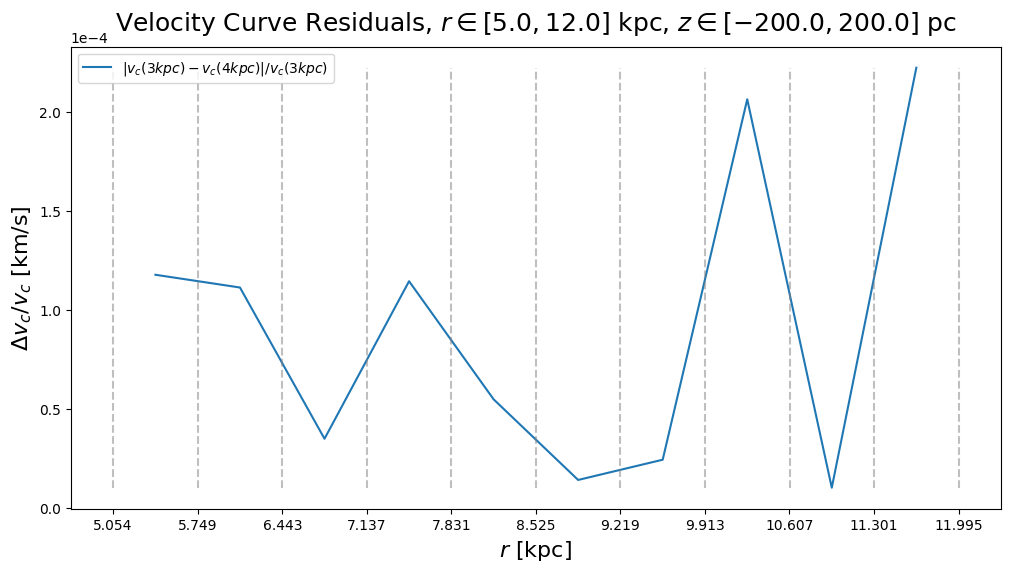

In [64]:
eq_label = r'$|v_c(3kpc)-v_c(4kpc)|/v_c(3kpc)$'

plot_residuals(samplers[1:], 4000, eq_label)

### RC region as +- 0.05

In [70]:
# Load run settings
path_1 = "/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-20-12-43-09_range0.05/run_settings.txt"
path_2 = "/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-19-14-46-55_range0.3/run_settings.txt"
paths = [path_1, path_2]

with open(path_1, 'rb') as handle:
    data = handle.read()
bin_setup = pickle.loads(data)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

0
1


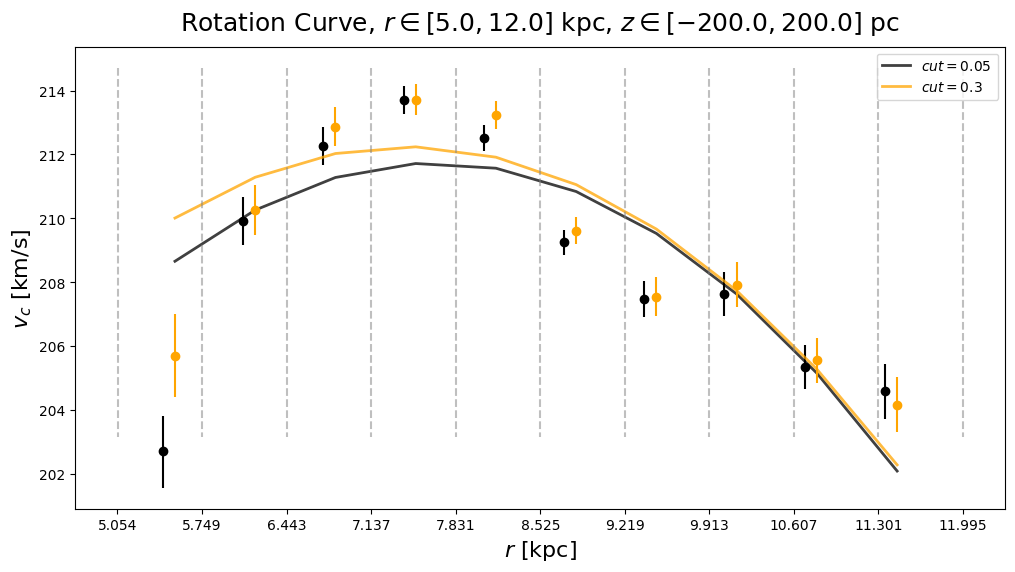

In [71]:
labels = []
for setup_path in paths:
    with open(setup_path, 'rb') as handle:
        bin_setup = pickle.loads(handle.read())
        labels.append(r'$cut = {}$ '.format(bin_setup['cut_range']))

sampler_path_1 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-20-12-43-09_range0.05/sampler_2022-09-20-12-43-09.h5'
sampler_path_2 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-19-14-46-55_range0.3/sampler_2022-09-19-14-46-55.h5'

samplers = [sampler_path_1, sampler_path_2]
plot_rotation_curve(True, samplers, labels, 4000)

### Reducing J-Ks Filter Range

In [72]:
# Load run settings
path_1 = "/home/svenpoder/repos/gaia-tools/out/mcmc_runs/reduced_J_Ks_range/run_settings.txt"
path_2 = "/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-19-14-46-55_range0.3/run_settings.txt"
paths = [path_1, path_2]

with open(path_1, 'rb') as handle:
    data = handle.read()
bin_setup = pickle.loads(data)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

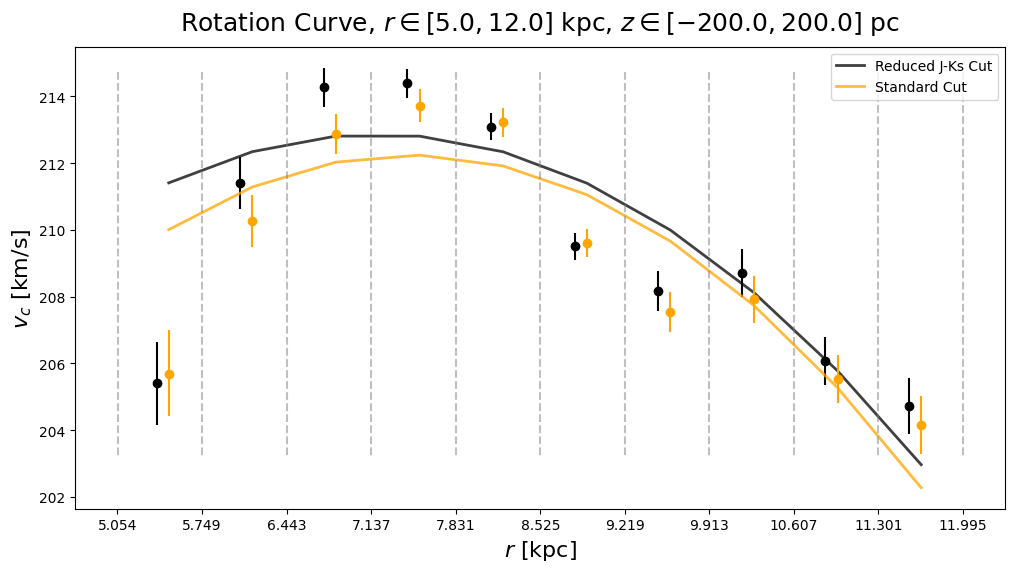

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[205.39982175 211.40572673 214.2699199  214.39337693 213.08104403
  209.51175994 208.16216189 208.70588394 206.06766796 204.70670087]
 [205.67238845 210.26951331 212.86555645 213.71746385 213.2249216
  209.61217839 207.53537824 207.92285258 205.54410948 204.15748699]]
(10,)


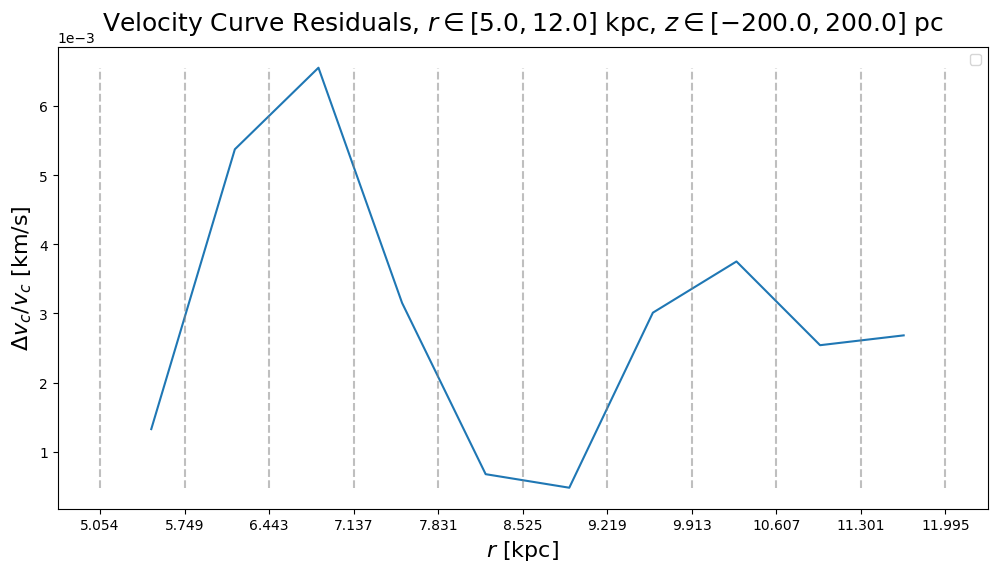

In [85]:
labels = ['Reduced J-Ks Cut', 'Standard Cut']
# for setup_path in paths:
#     with open(setup_path, 'rb') as handle:
#         bin_setup = pickle.loads(handle.read())
#         labels.append(r'$cut = {}$ '.format(bin_setup['cut_range']))

sampler_path_1 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/reduced_J_Ks_range/sampler_2022-09-20-13-00-28.h5'
sampler_path_2 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-19-14-46-55_range0.3/sampler_2022-09-19-14-46-55.h5'

samplers = [sampler_path_1, sampler_path_2]
plot_rotation_curve(True, samplers, labels, 4000)
plot_residuals(samplers, 4000, "")


### Increased Binning to 15

Sampler shape: (10000, 50, 15)


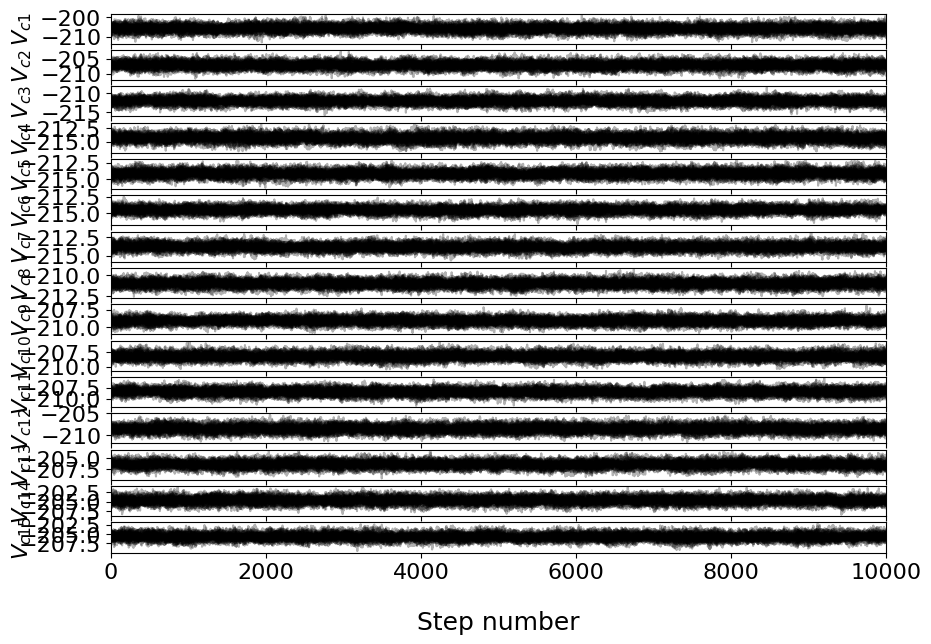

In [14]:
# Load run settings
path_1 = "/home/svenpoder/repos/gaia-tools/out/mcmc_runs/increased_bins_to_15/run_settings.txt"

paths = [path_1]

with open(path_1, 'rb') as handle:
    data = handle.read()
bin_setup = pickle.loads(data)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

sampler_path_1 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/increased_bins_to_15/sampler_2022-09-20-14-12-33.h5'
plot_walkers(sampler_path_1, 20000)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


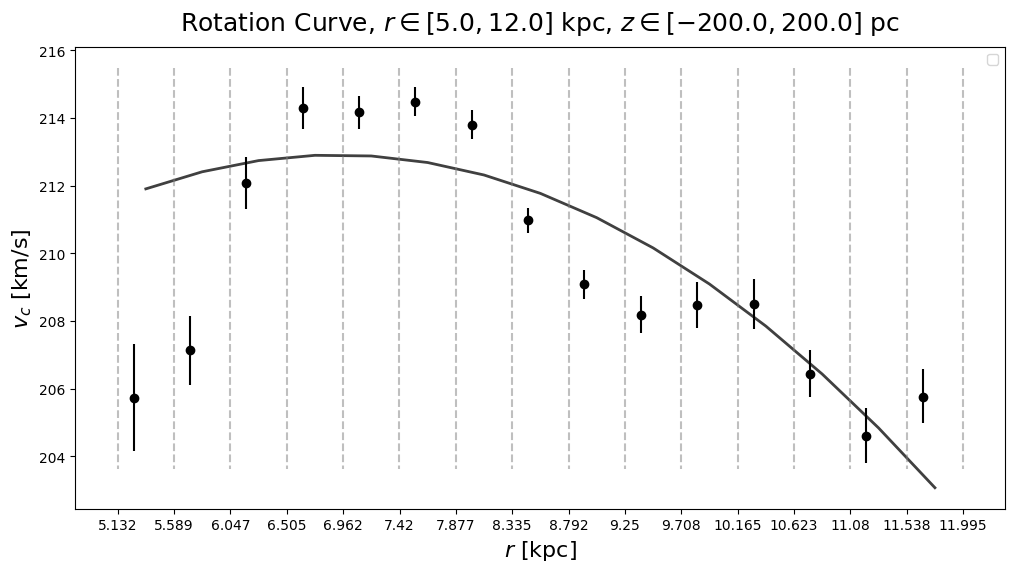

In [15]:
labels = [""]
samplers = [sampler_path_1]
plot_rotation_curve(True, samplers, labels, 20000)


### Fixed something in A parameter computation

['$h_r = 3000.0$ pc', '$h_r = 4000.0$ pc']
Sampler shape: (4500, 50, 10)


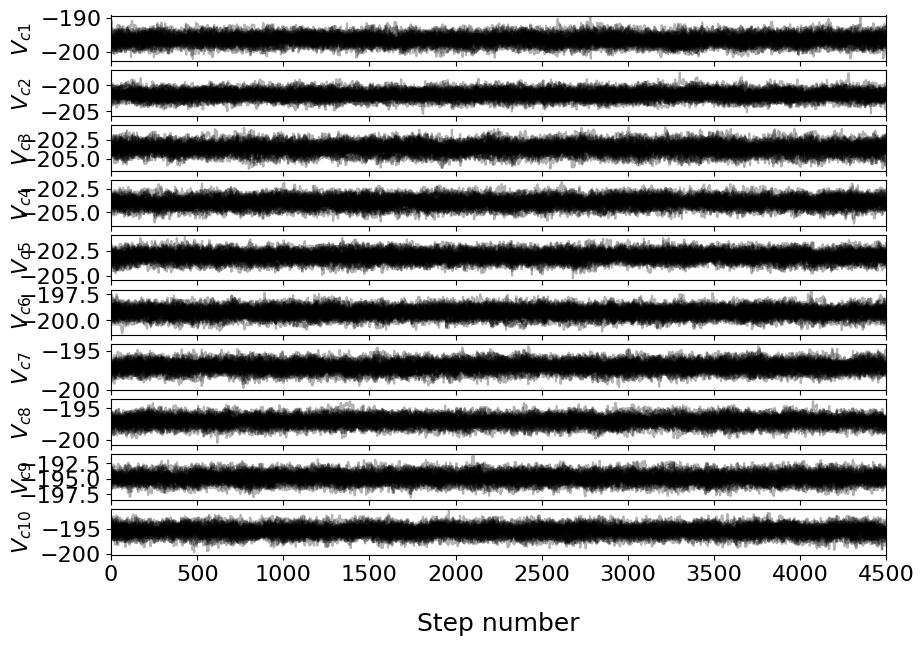

In [14]:
# Load run settings
path_1 = "/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-21-14-59-15_range0.3/run_settings.txt"
path_2 = "/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-21-15-14-20_range0.3/run_settings.txt"
paths = [path_1, path_2]

with open(path_1, 'rb') as handle:
    data = handle.read()
bin_setup = pickle.loads(data)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

sampler_path_1 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-21-14-59-15_range0.3/sampler_2022-09-21-14-59-15.h5'
sampler_path_2 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-21-15-14-20_range0.3/sampler_2022-09-21-15-14-20.h5'

labels = []
for setup_path in paths:
    with open(setup_path, 'rb') as handle:
        bin_setup = pickle.loads(handle.read())
        labels.append(r'$h_r = {}$ pc'.format(bin_setup['disk_scale']))
print(labels)

samplers = [sampler_path_1, sampler_path_2]
plot_walkers(sampler_path_1, 2500)

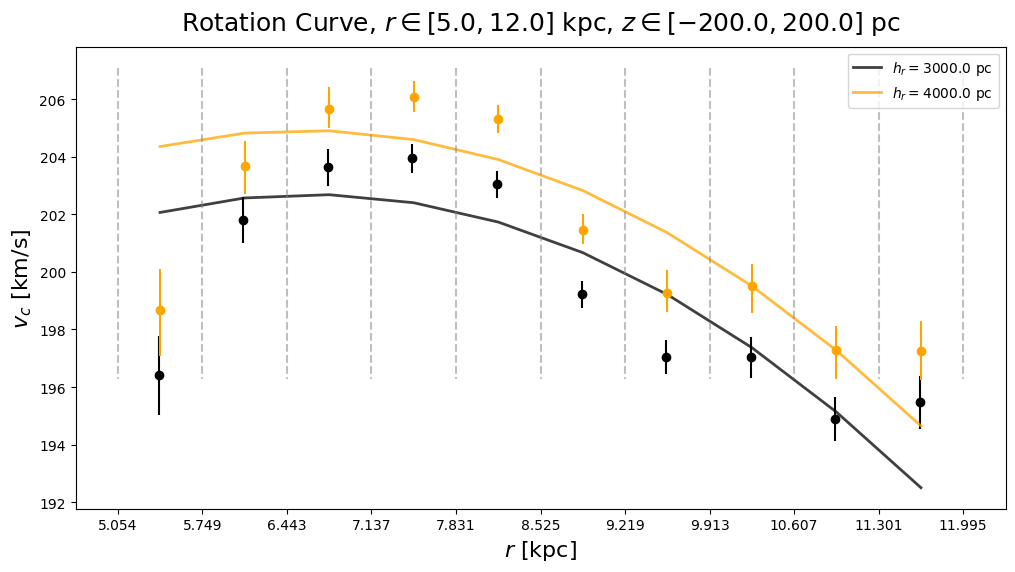

In [20]:
plot_rotation_curve(True, samplers, labels, 2500)

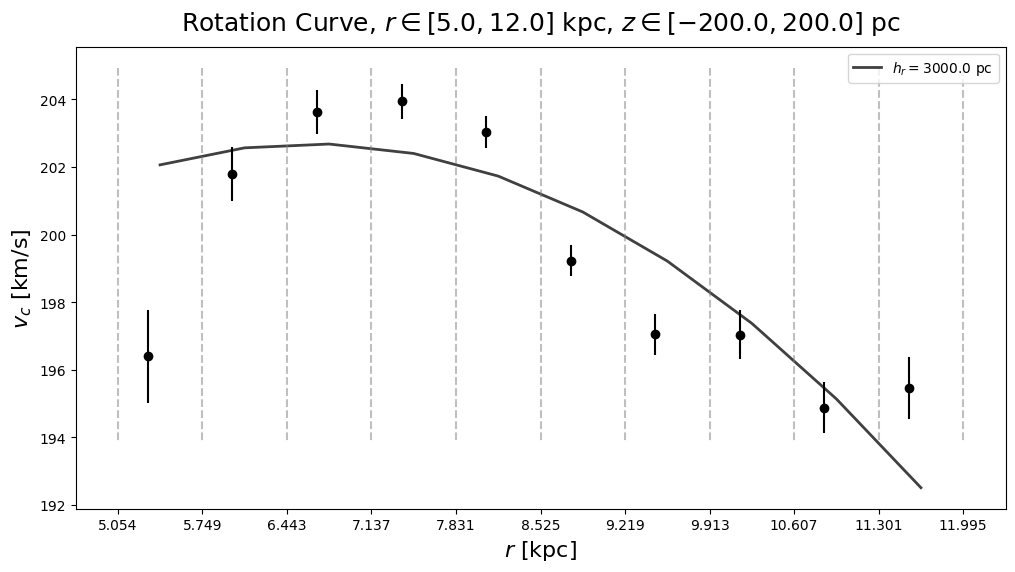

In [17]:
plot_rotation_curve(True, [samplers[0]], labels, 2500)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[196.41202794 201.80489824 203.63260557 203.94015618 203.04577094
  199.22797863 197.05338308 197.03170519 194.87483935 195.46742744]
 [198.66548743 203.66545965 205.64106103 206.09015254 205.31667665
  201.44018963 199.25796594 199.50979269 197.28765684 197.26552603]]
(10,)


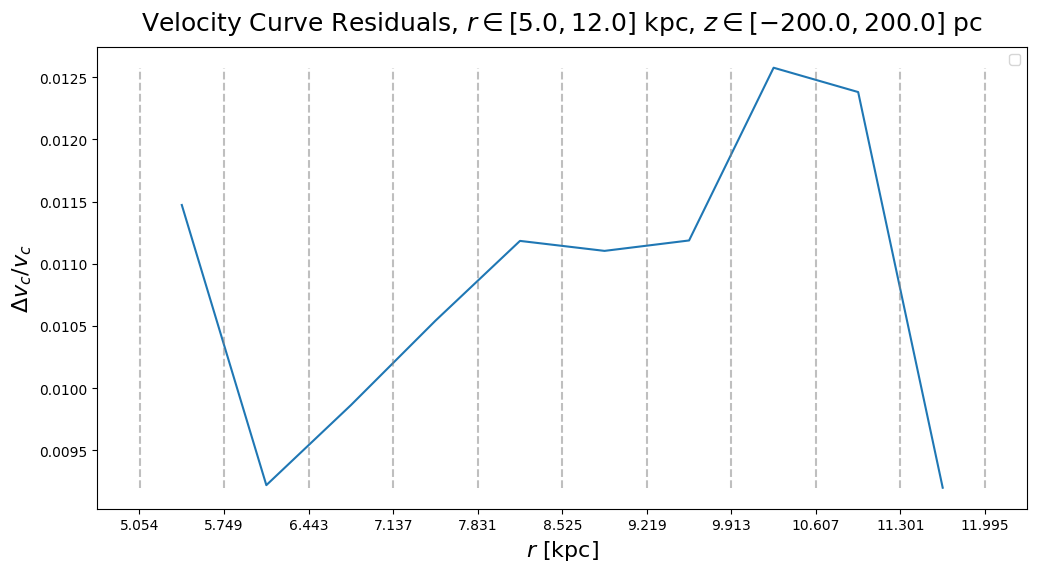

In [11]:
plot_residuals(samplers, 2500, "")

### Fixed - sign issues in analysis

['$h_r = 3000.0$ pc', '$h_r = 4000.0$ pc', '$h_r = 2000.0$ pc']
Sampler shape: (10000, 50, 10)


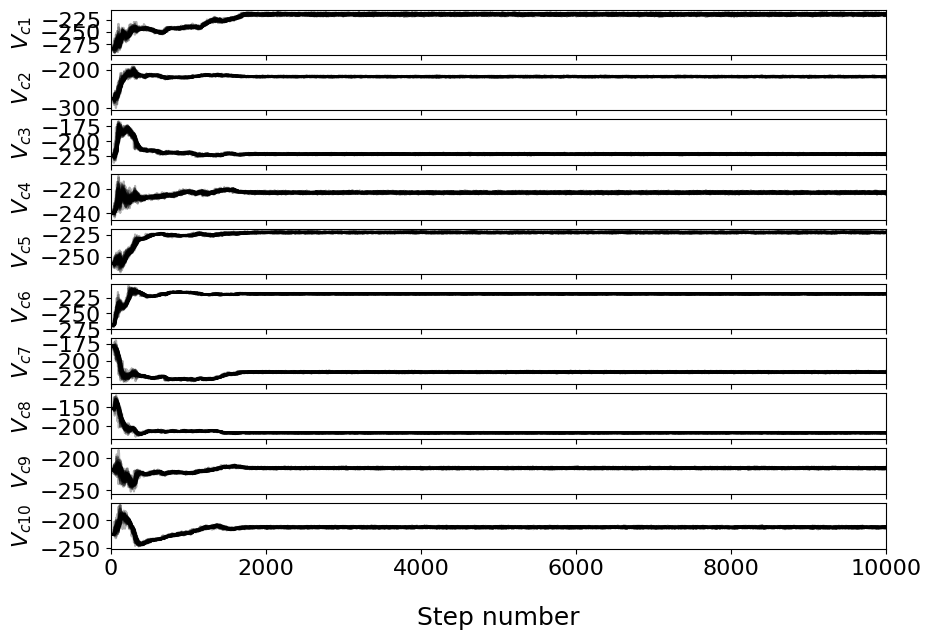

In [10]:
# Load run settings
path_1 = "/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-21-19-24-13_range0.3/run_settings.txt"
path_2 = "/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-21-20-01-08_range0.3/run_settings.txt"
path_3 = "/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-22-10-48-16_range0.3/run_settings.txt"
paths = [path_1, path_2, path_3]

with open(path_1, 'rb') as handle:
    data = handle.read()
bin_setup = pickle.loads(data)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

sampler_path_1 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-21-19-24-13_range0.3/sampler_2022-09-21-19-24-13.h5'
sampler_path_2 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-21-20-01-08_range0.3/sampler_2022-09-21-20-01-08.h5'
sampler_path_3 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-22-10-48-16_range0.3/sampler_2022-09-22-10-48-16.h5'
labels = []
for setup_path in paths:
    with open(setup_path, 'rb') as handle:
        bin_setup = pickle.loads(handle.read())
        labels.append(r'$h_r = {}$ pc'.format(bin_setup['disk_scale']))
print(labels)

samplers = [sampler_path_1, sampler_path_2, sampler_path_3]
plot_walkers(sampler_path_1, 0)

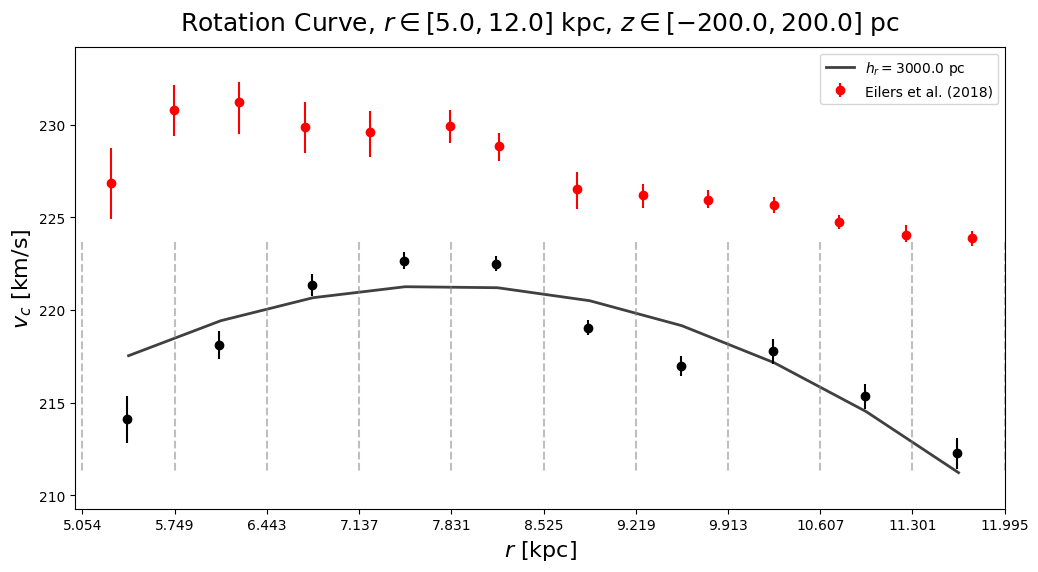

In [77]:
plot_rotation_curve(True, 
                    [samplers[0]], 
                    labels, 
                    2000, 
                    display_eilers=True,
                    display_bin_edges=True)

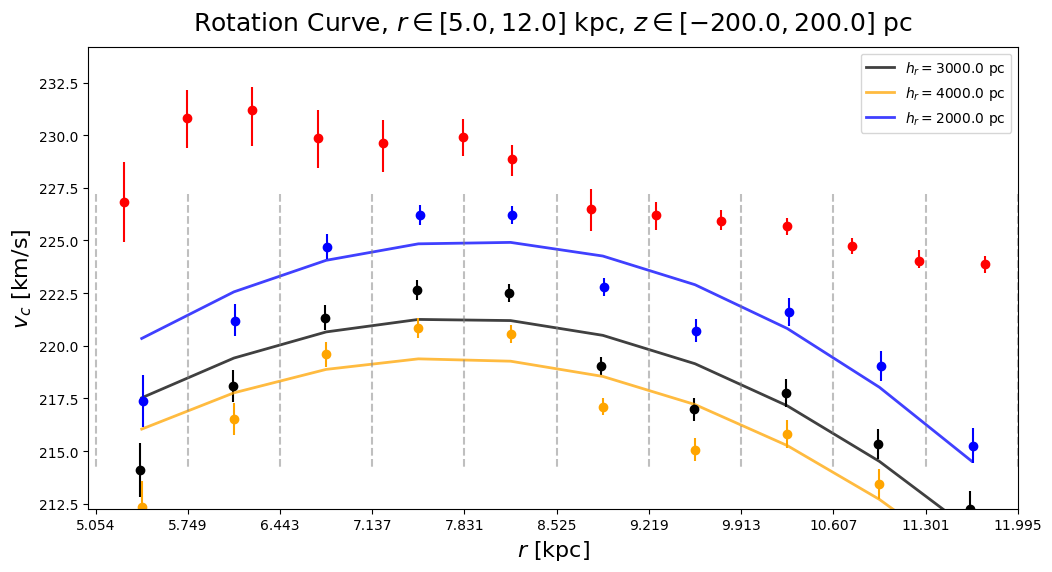

In [75]:
plot_rotation_curve(True, samplers, labels, 2000, display_eilers=True, display_bin_edges=True)

[[214.0916284  218.10372109 221.32550562 222.65516672 222.49776208
  219.03326147 216.97964566 217.76394612 215.33284553 212.27350835]
 [212.35321879 216.52807499 219.58777725 220.84186994 220.58245448
  217.1016156  215.07303517 215.81583668 213.42528009 210.73864988]]
(10,)


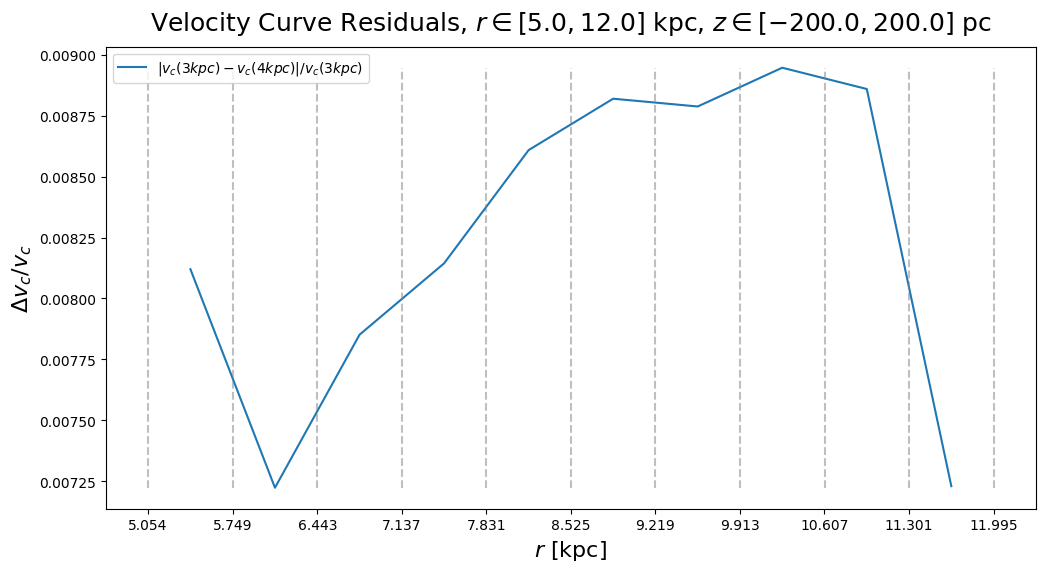

In [7]:
eq_label = r'$|v_c(3kpc)-v_c(4kpc)|/v_c(3kpc)$'
plot_residuals(samplers, 2000, eq_label)

Different velocity dispersion scale

In [9]:
folder_path = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-26-17-26-11_range0.3'
paths=[folder_path, "/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-21-19-24-13_range0.3"]
labels =[]
samplers=[]

# Load run settings
with open(folder_path + '/run_settings.txt', 'rb') as handle:
    data = handle.read()
bin_setup = pickle.loads(data)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

for folder_path in paths:
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')
    with open(folder_path + '/run_settings.txt', 'rb') as handle:
        bin_setup = pickle.loads(handle.read())
        labels.append(r'$h_\sigma = {}$ pc'.format(bin_setup['vlos_dispersion_scale']))
print(labels)

['$h_\\sigma = 21000.0$ pc', '$h_\\sigma = 16000.0$ pc']


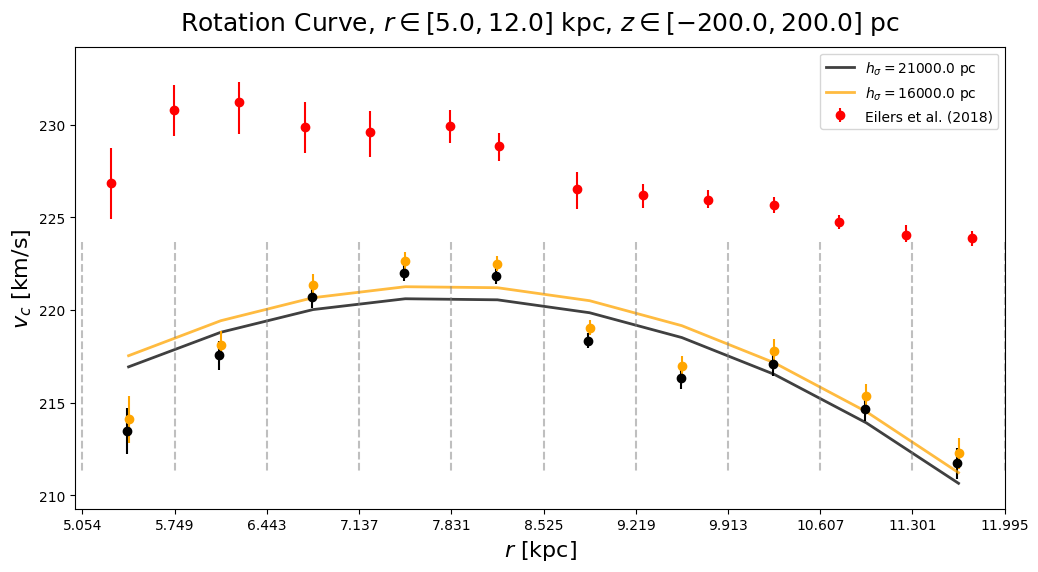

In [10]:
plot_rotation_curve(True, 
                    samplers, 
                    labels, 
                    2000, 
                    display_eilers=True,
                    display_bin_edges=True)

Sampler shape: (7000, 75, 10)


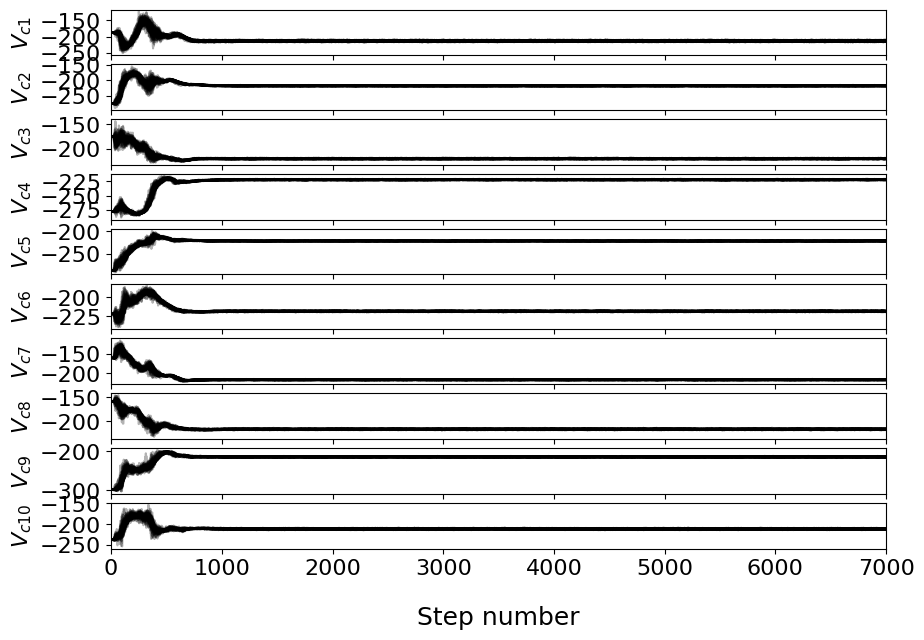

In [120]:
plot_walkers(samplers[0], 0)

In [11]:
folder_path = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-27-10-45-30_range0.15'
paths=[folder_path, "/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-09-21-19-24-13_range0.3"]
labels =[]
samplers=[]

# Load run settings
with open(folder_path + '/run_settings.txt', 'rb') as handle:
    data = handle.read()
bin_setup = pickle.loads(data)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

for folder_path in paths:
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')
    with open(folder_path + '/run_settings.txt', 'rb') as handle:
        bin_setup = pickle.loads(handle.read())
        labels.append(r'$cut = {}$ pc'.format(bin_setup['cut_range']))
print(labels)

['$h_\\sigma = 16000.0$ pc', '$h_\\sigma = 16000.0$ pc']


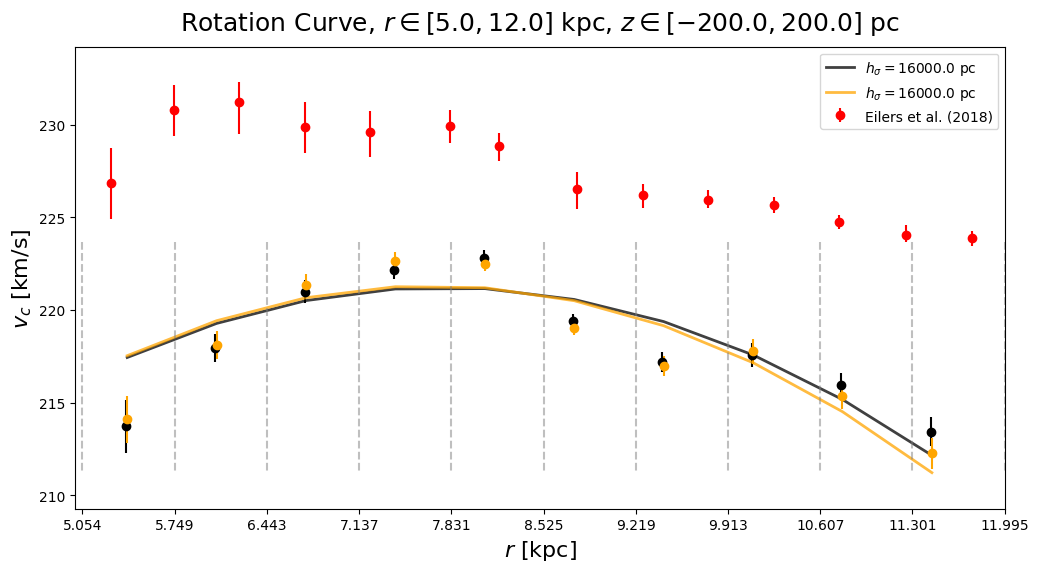

In [12]:
plot_rotation_curve(True, 
                    samplers, 
                    labels, 
                    2000, 
                    display_eilers=True,
                    display_bin_edges=True)